# (E4) 네이버 영화댓글 감성분석
### 데이터 준비  
데이터는 [naver sentiment movie corpus](https://github.com/e9t/nsmc)에서 master/ratings_train.txt, master/ratings_test.txt 를 다운 받았다  


### 데이터 확인
데이터를 확인하기위해 pandas를 사용하여 표로 만들어줬다

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 데이터 로더 구성 

- 데이터 중복 상태 점검
- stopword 제거
- word_to_index 구성


In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

### 인코딩 디코딩 함수 

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 데이터 셋 내 문장 길이 분포 및 지정

In [5]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))


문장길이 평균 :  15.969355837799927
문장길이 최대 :  116
문장길이 표준편차 :  12.843536204665021
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


### keras.preprocessing.sequence를 이용하여 padding  
방식은 pre로 하였다.

In [6]:
x_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=41)
x_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=41)


### validation set 설정

In [7]:
# validation set 37500건 분리
x_val = x_train[:37500]   
y_val = y_train[:37500]

# validation set을 제외한 나머지 37500건
partial_x_train = x_train[37500:]  
partial_y_train = y_train[37500:]


print(partial_y_train.shape)

(108682,)


In [10]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
# [[YOUR CODE]]
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [11]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
213/213 [==============================] - 9s 40ms/step - loss: 0.5330 - accuracy: 0.7295 - val_loss: 0.3645 - val_accuracy: 0.8406
Epoch 2/20
213/213 [==============================] - 1s 5ms/step - loss: 0.3371 - accuracy: 0.8560 - val_loss: 0.3468 - val_accuracy: 0.8504
Epoch 3/20
213/213 [==============================] - 1s 4ms/step - loss: 0.3012 - accuracy: 0.8741 - val_loss: 0.3397 - val_accuracy: 0.8537
Epoch 4/20
213/213 [==============================] - 1s 5ms/step - loss: 0.2769 - accuracy: 0.8859 - val_loss: 0.3425 - val_accuracy: 0.8545
Epoch 5/20
213/213 [==============================] - 1s 5ms/step - loss: 0.2533 - accuracy: 0.8983 - val_loss: 0.3506 - val_accuracy: 0.8527
Epoch 6/20
213/213 [==============================] - 1s 5ms/step - loss: 0.2293 - accuracy: 0.9095 - val_loss: 0.3622 - val_accuracy: 0.8519
Epoch 7/20
213/213 [==============================] - 1s 5ms/step - loss: 0.2032 - accuracy: 0.9227 - val_loss: 0.3816 - val_accuracy: 0.8485
Epoch

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


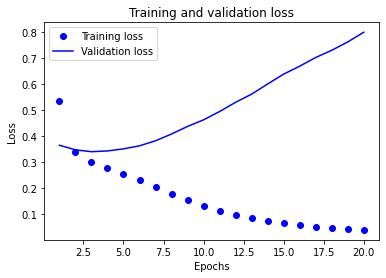

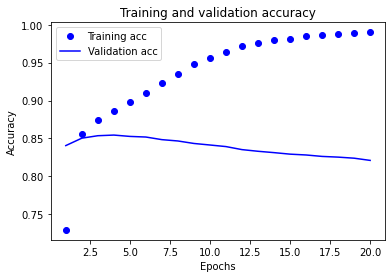

In [12]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [13]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.8320 - accuracy: 0.8157
[0.8320320248603821, 0.8157332539558411]


### 학습한 임베딩 레이어 확인

In [14]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()


강아지와 비슷한 벡터 표시

In [16]:

from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

word_vectors.similar_by_word("강아지")


[('바쁘', 0.8645966053009033),
 ('OUT', 0.8598277568817139),
 ('스틸', 0.8546355962753296),
 ('개도', 0.8539977073669434),
 ('곽경택', 0.8519953489303589),
 ('소란', 0.8434408903121948),
 ('줄께', 0.8428117036819458),
 ('do', 0.8402538895606995),
 ('모독', 0.8392202854156494),
 ('본인', 0.8305684328079224)]

### 한국어 Word2Vec 임베딩 활용하기 
word_vector_dim은 200으로 되있는것을 다운 받은거라 200 고정  
[다운링크](https://drive.google.com/file/d/0B0ZXk88koS2KbDhXdWg1Q2RydlU/view)

In [17]:
import os
import gensim
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko/ko.bin'

ko_model = gensim.models.Word2Vec.load(word2vec_file_path)
a = ko_model.wv.most_similar("강아지")
print(a)
vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size,word_vector_dim )
for i in range(4,vocab_size):
    if index_to_word[i] in ko_model:
        embedding_matrix[i] = ko_model[index_to_word[i]]

[('고양이', 0.7290453314781189), ('거위', 0.7185634970664978), ('토끼', 0.7056223750114441), ('멧돼지', 0.6950401067733765), ('엄마', 0.693433403968811), ('난쟁이', 0.6806551218032837), ('한마리', 0.6770296096801758), ('아가씨', 0.675035297870636), ('아빠', 0.6729634404182434), ('목걸이', 0.6512461304664612)]


/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  del sys.path[0]
/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


내가 학습한 임베딩에서는 강아지와 비슷한 벡터는 강아지와 크게 연관이 없어보이는 방면 
이미 학습된 임베딩에서 강아지와 비슷한 것을 봤을 때 고양이 거위 이런것이 나오는 것을 보면 임베딩이 잘되어있는것을 알 수 있었다

- **학습된 임베딩 용 모델 구성**

In [18]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [19]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
213/213 [==============================] - 10s 46ms/step - loss: 0.5592 - accuracy: 0.6998 - val_loss: 0.4439 - val_accuracy: 0.7945
Epoch 2/20
213/213 [==============================] - 5s 25ms/step - loss: 0.3976 - accuracy: 0.8212 - val_loss: 0.3815 - val_accuracy: 0.8300
Epoch 3/20
213/213 [==============================] - 5s 25ms/step - loss: 0.3338 - accuracy: 0.8568 - val_loss: 0.3634 - val_accuracy: 0.8398
Epoch 4/20
213/213 [==============================] - 5s 25ms/step - loss: 0.2970 - accuracy: 0.8760 - val_loss: 0.3701 - val_accuracy: 0.8354
Epoch 5/20
213/213 [==============================] - 6s 26ms/step - loss: 0.2658 - accuracy: 0.8929 - val_loss: 0.3636 - val_accuracy: 0.8433
Epoch 6/20
213/213 [==============================] - 5s 26ms/step - loss: 0.2439 - accuracy: 0.9034 - val_loss: 0.3764 - val_accuracy: 0.8452
Epoch 7/20
213/213 [==============================] - 5s 25ms/step - loss: 0.2181 - accuracy: 0.9165 - val_loss: 0.3918 - val_accuracy: 0.839

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


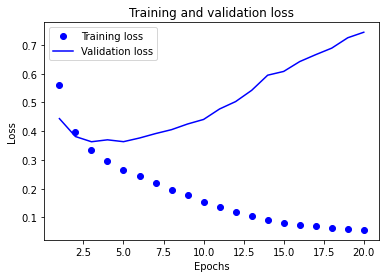

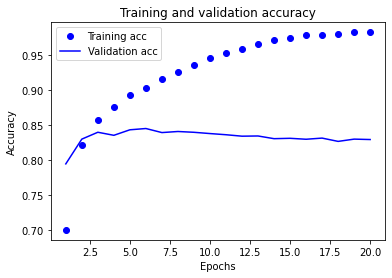

In [20]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 학습된 임베딩 레이어 에폭 조정
이미 학습된 임베딩이라 그런지 과적합이 금방 일어난다. 과적합 판단 여부는 validation loss가 줄어들다가 상승할때를 잡았다. 
3번째를 지나서 과적합이 일어났으므로 에폭을 3번으로 바꾸고 다시하였다.

In [21]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [22]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=3  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/3
213/213 [==============================] - 5s 25ms/step - loss: 0.5428 - accuracy: 0.7165 - val_loss: 0.4404 - val_accuracy: 0.7941
Epoch 2/3
213/213 [==============================] - 5s 24ms/step - loss: 0.3953 - accuracy: 0.8210 - val_loss: 0.3811 - val_accuracy: 0.8300
Epoch 3/3
213/213 [==============================] - 5s 24ms/step - loss: 0.3341 - accuracy: 0.8554 - val_loss: 0.3634 - val_accuracy: 0.8417


이제 학습된 임베딩을 활용하여 한것을 테스트 하였다

In [23]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3767 - accuracy: 0.8352
[0.3766663074493408, 0.8351811766624451]


83프로로 학습된 임베딩 없이 한 모델의 정확도 81프로의 수치보다 약간 높아졌다.하지만 너무 적은 수치라 모델을 다른것을 사용하거나 하이퍼파라미터를 변경해야한다고 생각한다. 하지만 둘다 해보기엔 무리가 있어보여 모델을 다른것을 해보기로 하였다.

## LSTM MODEL

In [24]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(256))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 256)               467968    
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 2056      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 2,470,033
Trainable params: 2,470,033
Non-trainable params: 0
_________________________________________________________________


In [25]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
213/213 [==============================] - 8s 39ms/step - loss: 0.4508 - accuracy: 0.7847 - val_loss: 0.3610 - val_accuracy: 0.8387
Epoch 2/20
213/213 [==============================] - 8s 37ms/step - loss: 0.3284 - accuracy: 0.8574 - val_loss: 0.3226 - val_accuracy: 0.8589
Epoch 3/20
213/213 [==============================] - 8s 37ms/step - loss: 0.2804 - accuracy: 0.8825 - val_loss: 0.3276 - val_accuracy: 0.8609
Epoch 4/20
213/213 [==============================] - 8s 37ms/step - loss: 0.2477 - accuracy: 0.8984 - val_loss: 0.3162 - val_accuracy: 0.8692
Epoch 5/20
213/213 [==============================] - 8s 37ms/step - loss: 0.2161 - accuracy: 0.9126 - val_loss: 0.3360 - val_accuracy: 0.8662
Epoch 6/20
213/213 [==============================] - 8s 37ms/step - loss: 0.1840 - accuracy: 0.9270 - val_loss: 0.3449 - val_accuracy: 0.8629
Epoch 7/20
213/213 [==============================] - 8s 37ms/step - loss: 0.1515 - accuracy: 0.9417 - val_loss: 0.4034 - val_accuracy: 0.8616

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


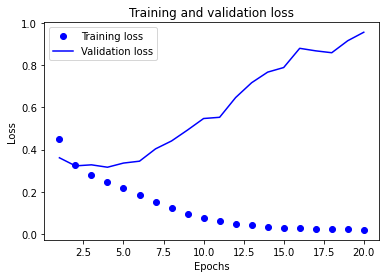

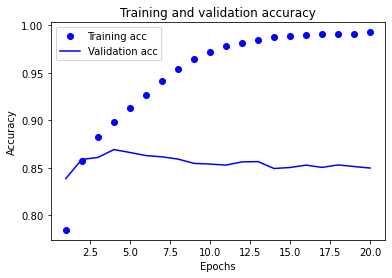

In [26]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

위의 그래프 상에 벨리데이션 로스 값이 올라가는 시점이 5에폭이라 4에폭으로 조정하였다.

In [27]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(256))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               467968    
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 2056      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 2,470,033
Trainable params: 2,470,033
Non-trainable params: 0
_________________________________________________________________


In [28]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=4  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/4
213/213 [==============================] - 8s 38ms/step - loss: 0.4565 - accuracy: 0.7803 - val_loss: 0.3660 - val_accuracy: 0.8385
Epoch 2/4
213/213 [==============================] - 8s 37ms/step - loss: 0.3260 - accuracy: 0.8588 - val_loss: 0.3231 - val_accuracy: 0.8600
Epoch 3/4
213/213 [==============================] - 8s 37ms/step - loss: 0.2785 - accuracy: 0.8832 - val_loss: 0.3149 - val_accuracy: 0.8650
Epoch 4/4
213/213 [==============================] - 8s 38ms/step - loss: 0.2464 - accuracy: 0.8989 - val_loss: 0.3273 - val_accuracy: 0.8639


In [29]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3355 - accuracy: 0.8600
[0.33552634716033936, 0.8600199222564697]


- **LSTM MODEL 정확도 86%**

## GlobalMaxPooling1D MODEL

In [30]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 200)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 1608      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [31]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
213/213 [==============================] - 5s 23ms/step - loss: 0.6878 - accuracy: 0.5514 - val_loss: 0.6472 - val_accuracy: 0.6253
Epoch 2/20
213/213 [==============================] - 5s 23ms/step - loss: 0.5907 - accuracy: 0.6867 - val_loss: 0.5445 - val_accuracy: 0.7273
Epoch 3/20
213/213 [==============================] - 5s 23ms/step - loss: 0.5113 - accuracy: 0.7514 - val_loss: 0.4898 - val_accuracy: 0.7637
Epoch 4/20
213/213 [==============================] - 5s 23ms/step - loss: 0.4626 - accuracy: 0.7823 - val_loss: 0.4616 - val_accuracy: 0.7791
Epoch 5/20
213/213 [==============================] - 5s 23ms/step - loss: 0.4285 - accuracy: 0.8025 - val_loss: 0.4373 - val_accuracy: 0.7950
Epoch 6/20
213/213 [==============================] - 5s 23ms/step - loss: 0.4023 - accuracy: 0.8188 - val_loss: 0.4260 - val_accuracy: 0.8012
Epoch 7/20
213/213 [==============================] - 5s 23ms/step - loss: 0.3808 - accuracy: 0.8309 - val_loss: 0.4130 - val_accuracy: 0.8107

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


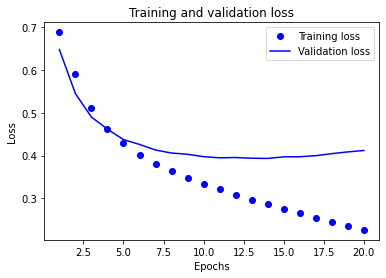

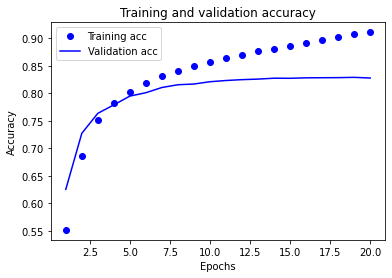

In [32]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

벨리데이션 로스 값이 11에서 12로 갈때 로스값이 증가하여 에폭값을 11로 정하였다

In [33]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 200)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 1608      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [34]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=11  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/11
213/213 [==============================] - 5s 24ms/step - loss: 0.6877 - accuracy: 0.5703 - val_loss: 0.6570 - val_accuracy: 0.6346
Epoch 2/11
213/213 [==============================] - 5s 23ms/step - loss: 0.6289 - accuracy: 0.6723 - val_loss: 0.5998 - val_accuracy: 0.7067
Epoch 3/11
213/213 [==============================] - 5s 23ms/step - loss: 0.5724 - accuracy: 0.7302 - val_loss: 0.5507 - val_accuracy: 0.7400
Epoch 4/11
213/213 [==============================] - 5s 23ms/step - loss: 0.5222 - accuracy: 0.7674 - val_loss: 0.5105 - val_accuracy: 0.7680
Epoch 5/11
213/213 [==============================] - 5s 23ms/step - loss: 0.4826 - accuracy: 0.7915 - val_loss: 0.4817 - val_accuracy: 0.7859
Epoch 6/11
213/213 [==============================] - 5s 24ms/step - loss: 0.4495 - accuracy: 0.8100 - val_loss: 0.4609 - val_accuracy: 0.7966
Epoch 7/11
213/213 [==============================] - 5s 23ms/step - loss: 0.4223 - accuracy: 0.8246 - val_loss: 0.4464 - val_accuracy: 0.8024

In [35]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4146 - accuracy: 0.8157
[0.4146278500556946, 0.8156926035881042]


- **GlobalMaxPooling1D MODEL 정확도81.6%**

# 고찰 
학습된 임베딩 모델을 불러와서 3가지 모델로 오버피팅 되지않게 조정하고 테스트를 해보았다.  
가장 좋은 결과는 LSTM모델의 것이었는데 86%로 목표치에 도달할 수 있었다.  
### 아쉬운 점
하이퍼파라미터 수정은 LSTM의 모델만 조금 수정하였었는데 그것이 가장 높게나와 모델다양화가 좋은 선택인지 하이퍼파라미터가 좋은 선택인지 알기 힘들어져서 나중에 정확도를 올리기위해서 선뜻 뭐부터하기 힘들어졌는데 간단하게 수정하기 편한것은 하이퍼파라미터라서 나중에는 하이퍼파라미터부터 할 것 같다.